# Regularización

Como hemos venido discutiendo en clase y en los talleres, lo modelos de aprendizaje profundo tienen una alta propensión hacia el **sobre-ajuste**, lo cual es un gran problema si no se controla. Recordemos que estamos buscando una buena generalización para predecir sobre con nuevos ejemplos/datos. 

En este taller vamos a revisar la técnica de regularización en los modelos de redes neuronales.

Primero cargamos los paquetes que vamos a usar.

In [1]:
# importación de paquetes
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # tamaño de los gráficos
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

C:\Users\andres\Downloads\Taller1\reg_utils.py:53: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], layer_dims[l-1])
C:\Users\andres\Downloads\Taller1\reg_utils.py:54: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(parameters['W' + str(l)].shape == layer_dims[l], 1)


**Enunciado del problema**: como experto en aprendizaje computacional, se le acaba de encomendar la tarea de recomendar la ubicación de nuevas tiendas con el fin de maximizar las ventas.  

Se le proporciona el siguiente conjunto de datos sobre el conjunto de tiendas que tiene la empresa en este momento.

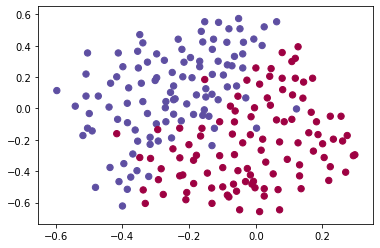

In [3]:
train_X, train_Y, test_X, test_Y=load_2D_dataset()

Cada punto corresponde con la ubicación de una tienda.
- Si el punto es azul, la tienda tiene un buen volumen de ventas
- Si el punto es rojo, quiere decir que el nivel de ventas de esa tienda no es bueno

**Objetivo**: Utilice un modelo de aprendizaje profundo para encontrar las ubicaciones de las tiendas que son más propensas al éxito en ventas, y donde se debe centrar la próxima campaña publicitaria.

**Problema analítico**: Este conjunto de datos, aunque un poco ruidoso, parece que podría ser separado de manera adecuada por una diagonal que separa la parte superior izquierda (en azul) de la parte inferior derecha (en rojo). 

Primero intente desarrollar un modelo no-regularizado. Luego aprenderá a regularizarlo y decidir cuál modelo elegir para resolver el problema de la empresa que lo contrató. 

## 1 - Modelo no-regularizado

Vamos a utilizar el siguiente modelo de red sin regularización. 

Luego va a implementar:
- *regularizacion tipo-L2* con las funciones "`coste_con_regularizacion()`" y "`retropropagacion_con_regularizacion()`"

Lea el código abajo para familiarizarse con el modelo.

In [ ]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0):
    """
    Implementa la red: LINEAL->RELU->LINEAL->RELU->LINEAL->SIGMOIDE.
    
    Input:
    X: datos de entrada de tamaño (n_x, número de ejemplos)
    Y: vector de etiquetas (1 para azul y 0 para rojo), observadas de tamaño (n_y, número de ejemplos)
    learning_rate: tasa de aprendizaje de la regla de actualización por G.D. 
    num_iterations: número de iteraciones del bucle de optimización
    print_cost: Si es True, muestra el coste cada 10000 iteraciones
    lambd: (hiper)parámetro de regularización, escalar
    Output:
    parameters: parámetros aprendidos por el modelo, usados para predecir
    """
        
    grads = {}
    costs = []                            # guarda el coste
    m = X.shape[1]                        # numero de ejemplos
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Inicializa los parámetros del diccionario.
    parameters = initialize_parameters(layers_dims)

    # Bucle (G.D.)

    for i in range(0, num_iterations):
       
        #Propagación hacia delante 
        a3, cache = forward_propagation(X, parameters)
        
        # Coste
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = coste_con_regularizacion(a3, Y, parameters, lambd)
            
        # Retro-propagacion
        if lambd == 0:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = retropropagacion_con_regularizacion(X, Y, cache, lambd)

        
        # Actualización de parámetros
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Imprime la pérdida cada 10000 iteraciones
        if print_cost and i % 10000 == 0:
            print("Coste tras la iteración {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # grafica el coste
    plt.plot(costs)
    plt.ylabel('Coste')
    plt.xlabel('Iteraciones (x1,000)')
    plt.title("Tasa de aprendizaje =" + str(learning_rate))
    plt.show()
    
    return parameters

Entrenemos el modelo sin ninguna regularización, y observe la precisión sobre los conjuntos de entrenamiento y prueba.

In [ ]:
parameters = model(train_X, train_Y)
print ("Sobre el entrenamiento:")
predictions_train = predict(train_X, train_Y, parameters)
print ("Sobre la prueba:")
predictions_test = predict(test_X, test_Y, parameters)

La precisión de entrenamiento es de 94.8% mientras que la precisión de prueba es de 91.5%. Este es el modelo de base (el cual podemos intentar mejorar, por ejemplo mediante regularización). 

Ejecute el siguiente código para graficar la frontera de decisión del modelo.

In [ ]:
plt.title("Modelo sin regularización")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.flatten())

Este modelo no-regularizado se está sobre-ajustando al conjunto de entrenamiento. Esto se puede ver ya que se ajusta a los puntos que muestran mayor ruido. 

Veamos ahora la técnica de regularización para reducir el sobre-ajuste.

## 2 - Regularización-L2

El método más usual para evitar el sobre-ajuste es la **regularización-L2**. Consiste en modificar apropiadamente la función de coste, tal que:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
pasa a ser formulada como:
$$J_{regularizada} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{entropía cruzada} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{coste de regularizacion-L2} \tag{2}$$

Ahora, modifique el coste y constate el cambio en el ajuste.

**Ejercicio**: Implemente `coste_con_regularizacion()` para computar el coste de acuerdo con la fórmula (2). Para calcular $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$  , utilice :
```python
np.sum(np.square(W[l]))
```
Nótese que debe hacer esto para $W^{[1]}$, $W^{[2]}$ y $W^{[3]}$, y luego sumar los tres términos y multiplicar por $ \frac{1}{m} \frac{\lambda}{2} $.

In [ ]:
# FUNCIÓN A CALIFICAR: coste_con_regularizacion

def coste_con_regularizacion(A3, Y, parameters, lambd):
    """
    Implementa la función de coste con regularización-L2 (ver (2)).
    Input:
    A3: post-activación, salida de la propagación hacia delante, de dimensiones (tamaño de salida, número de ejemplos)
    Y: vector de etiquetas, de tamaño (tamaño de salida, número de ejemplos)
    parameters: diccionario python con los parámetros del modelo
    Salida:
    cost: valor de la función de coste regularizada 
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # salida de la parte de entropía-cruzada del coste
    
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
    L2_regularization_cost = 
    ### TERMINE EL CÓDIGO AQUÍ ###
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [ ]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("coste = " + str(coste_con_regularizacion(A3, Y_assess, parameters, lambd = 0.1)))

**Salida esperada**:

<table> 
    <tr>
    <td>
    **coste**
    </td>
        <td>
    1.78648594516
    </td>
    
    </tr>

</table> 

Desde luego, como se ha cambiado la función de pérdida, también se debe modificar la retro-propagación. Todos los gradiantes deben ser calculados con respecto al nuevo coste. 

**Ejercicio**: Implemente los cambios requeridos en la retro-propagación tomando en cuenta la regularización. Los cambios solo se refieren al cálculo de dW1, dW2 y dW3. Para cada uno, debe añadir el gradiente del término de regularización $\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$.

In [ ]:
# FUNCIÓN A CALIFICAR: retropropagacion_con_regularizacion

def retropropagacion_con_regularizacion(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
    dW3 = 
    ### TERMINE EL CÓDIGO AQUÍ ###
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
    dW2 = 
    ### TERMINE EL CÓDIGO AQUÍ ###
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    ### EMPIEZE EL CÓDIGO AQUÍ ### (≈ 1 línea de código)
    dW1 = 
    ### TERMINE EL CÓDIGO AQUÍ ###
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [ ]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = retropropagacion_con_regularizacion(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = "+ str(grads["dW1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("dW3 = "+ str(grads["dW3"]))

**Salida esperada**:

<table> 
    <tr>
    <td>
    **dW1**
    </td>
        <td>
    [[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
    </td>
    </tr>
    <tr>
    <td>
    **dW2**
    </td>
        <td>
    [[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
    </td>
    </tr>
    <tr>
    <td>
    **dW3**
    </td>
        <td>
    [[-1.77691347 -0.11832879 -0.09397446]]
    </td>
    </tr>
</table> 

Ahora ejecute el modleo con regularización L2 $(\lambda = 0.7)$. La funcion `model()` utiliza: 
- `coste_con_regularizacion` en lugar de `compute_cost`
- `retropropagacion_con_regularizacion` en lugar de `backward_propagation`

In [ ]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("Sobre el conjunto de entrenamiento:")
predictions_train = predict(train_X, train_Y, parameters)
print ("Sobre el conjunto de prueba:")
predictions_test = predict(test_X, test_Y, parameters)

Felicitaciones, la precisión de prueba se incrementó en un 93%. 

Los datos de entrenamiento ya no están sobre-ajustados. Compruébelo graficando ls frontera de decisión.

In [ ]:
plt.title("Modelo con regularización-L2")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y.flatten())

**Resultados de los dos modelos**: 

<table> 
    <tr>
        <td>
        **Modelo**
        </td>
        <td>
        **Precisión de entrenamiento**
        </td>
        <td>
        **Precisión de prueba**
        </td>

    </tr>
        <td>
        Red de 3 capas sin regularización
        </td>
        <td>
        95%
        </td>
        <td>
        91.5%
        </td>
    <tr>
        <td>
        Red de 3 capas con regularización
        </td>
        <td>
        94%
        </td>
        <td>
        93%
        </td>
    </tr>
</table> 

Nótese que la regularización perjudica el desempeño sobre el conjunto de entrenamiento. Esto es porque limita la abilidad de la red a sobre-ajustarlo. De todos modos, el sistema se ve beneficiado al tener una mejor precisión en prueba. 

**Anotaciones**:
- El valor de $\lambda$ es un (hiper)parámetro que se puede optimizar sobre el conjunto de validación.
- La regularización-L2 vuelve la frontera de decisión más suave. Si $\lambda$ es muy grande, también sería posible tener demasiada "sobre-generalización", lo cual llevaría a un mayor sesgo del modelo.

<font color='blue'>
**Para recordar:** 

La regularización-L2 se basa en el principio que un modelo sencillo (con pesos pequeños o casi nulos) que obtenga resultados al menos tan buenos como los de otro modelo más comlejo (pesos más grandes para todos los predictores), es mejor. Por ello, mediante la penalización sobre los valores de los pesos al cuadrado en la función de pérdida se consiguen pesos con valores reducidos. Así se consigue un mayor coste de tener mayores pesos, obteniendo un modelo más suave o general, donde la salida cambia más gradual y lentamente a medida que el input de entrada cambia. 
